<a href="https://colab.research.google.com/github/koalalovepabro/Deep-Learning/blob/main/Dogs%20vs%20Cats%20keras_%2303_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In this notebook, i will be bringing you through the use of **Transfer Learning** in pretrained models like VGG16, Resnet etc to solve similar tasks; image classification of Dogs and Cats. We will see how we can use these pretrained models as feature extractors to generate features to be fed into another classifier, as well as finetuning these models to solve our problem.  
The notebook will be using Keras, a high-level API that allow us to build prototypes quickly with minimum coding, without loss in performance.  
* Building a custom CNN
* Using a pre-trained model as feature extractor (VGG16)
* Fine tuning an existing pre-trained model (ResNet50)


I hope that after reading the notebook, you guys can not only apply these transfer learning techniques for future problems, but also appreciate the power of using pre-trained models that the awesome researchers have came up with :)

# Table of Content
1.  [Dog vs Cat Dataset](#sec1)  
    * [1.1 Extracting Zip file](#sec1.1)  
    * [1.2 Data Formatting](#sec1.2)
    * [1.3 Generating mini batches for training](#sec1.3)  
2. [CNN Architecture](#sec2)  
    * [2.1 CNN from scratch](#sec2.1)  
    * [2.2 Transfer Learning](#sec2.2) 
        * [2.2.1 Feature Extraction](#sec2.2.1) 
        * [2.2.2 Fine Tuning](#sec2.2.2)  
3. [Results](#sec3)  


In [ ]:
#Download Dependencies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile
import glob
import os
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from kaggle_datasets import KaggleDatasets

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.resnet50 import preprocess_input

Using TensorFlow backend.


<a id="sec1"></a>
# [1. Dogs vs Cats Dataset](#sec1)

<a id="sec1.1"></a>
## [1.1 Extracting Zip file](#sec1.1)
The data files provided are in .zip extension, which needs to be unzipped before we can access the images for our training later on. We will be using the [zipfile](https://docs.python.org/3/library/zipfile.html) library that provides a simple way for us to unzip these .zip files

In [ ]:
import zipfile
import glob

zip_file = glob.glob('/kaggle/input/dogs-vs-cats/*.zip')  #return any files with .zip extension
print(zip_file)

#extract file into a temp folder
def extract_zip(file):
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall("temp")
        
#extract both train and test1 zip
for files in zip_file:
    extract_zip(files)

['/kaggle/input/dogs-vs-cats/test1.zip', '/kaggle/input/dogs-vs-cats/train.zip']


In [ ]:
#instantiate the constants
batch_size = 16
img_size = 224
epochs = 5

In [ ]:
print(len(os.listdir('/kaggle/working/temp/train')), "training data")
print(len(os.listdir('/kaggle/working/temp/test1')), "test data")
os.listdir("temp")

25000 training data
12500 test data


['test1', 'train']

<a id='sec1.2'></a>
## [1.2 Data Formatting](#sec1.2)

In our data formatting, we will generate the respective labels for **dogs (1)** and **cats (0)** for our training data. File path will also be collected as a column for our dataframe so that it can be used to load and train our images

In [ ]:
def gen_label(directory):
    label = []
    for file in os.listdir(directory):
        if (file.split('.')[0] == 'dog'):
            label.append(str(1))
        elif (file.split('.')[0] == 'cat'):
            label.append(str(0))
    return label
    #print(len(label),"files in", directory)
    
def get_path(directory):
    path = []
    for files in os.listdir(directory):
        path.append(files)
    return path

train_y = gen_label('temp/train')  # 정답 데이터 (y) : 1과 0의 값들이 담긴 리스트. Label
train_x = get_path('temp/train')   # 학습 데이터 (x) : 파일명들이 담긴 리스트. input data
test_x = get_path('temp/test1')    # test 데이터

In [ ]:
train_y[:5]

['1', '1', '1', '1', '0']

In [ ]:
train_x[:5]

['dog.1755.jpg',
 'dog.10240.jpg',
 'dog.2042.jpg',
 'dog.3252.jpg',
 'cat.10566.jpg']

        filename category
0   dog.1755.jpg        1
1  dog.10240.jpg        1
2   dog.2042.jpg        1
3   dog.3252.jpg        1
4  cat.10566.jpg        0


Text(0.5, 1.0, 'Data Distribution')

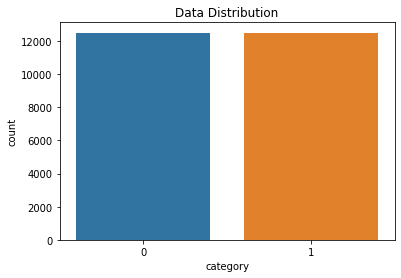

In [ ]:
df = pd.DataFrame({'filename': train_x,
                  'category': train_y})
print(df.head())

sns.countplot(x='category',data = df).set_title("Data Distribution")

In [ ]:
df['category'].value_counts()

1    12500
0    12500
Name: category, dtype: int64

Train Data에는 Dog(1)와 Cat(0)가 각각 12,500개씩 있다.

### Lets visualise one of the training image

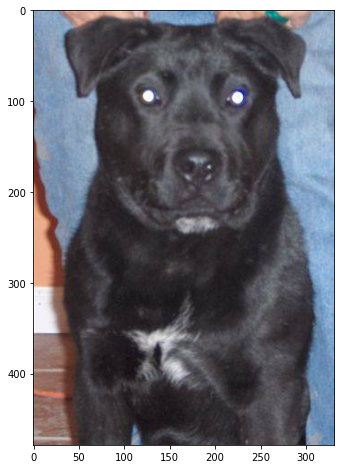

In [ ]:
# Change working directory
os.chdir('temp/train')

img = load_img(df['filename'].iloc[0]) # 0번째에 있는 데이터를 load하고, img로 저장
  
# Displaying the image 
plt.figure(figsize=(8,8))
plt.imshow(img)

<a id="sec1.3"></a>
## [1.3 Generating mini batches for training](#sec1.3)

Before we move on from here, i would like discuss the following terms that you might have often come across; **Batch Gradient Descent**, **Stochastic Gradient Descent**, **Mini-Batch Gradient Descent**.  

In machine learning terms, the word **gradient descent** refers to a specific optimization algorithm whose purpose it to minimise the loss function of any machine learning algorithm. Gradient Descent does so by calculating the gradient of the weights parameters with respect to the loss function, and using it to find a global minimum of the loss function.

**Batch Gradient Descent** uses the entire training data to make one gradient computation; which results in slow convergence since the gradient descent only makes a single step with every epoch.  
**Stochastic Gradient Descent** makes a gradient calculation with a single training sample, which will result in loss of speedup from the vectorization.  
**Mini-Batch Gradient Descent** uses a mini-batches of training example for each gradient calculation; which makes convergence faster, and at the same time, utilise the speed up from vectorization.

We will first split our training data into training and validation set


In [ ]:
# train & validation 데이터 분할
train_df, valid_df = train_test_split(df, test_size=0.25) # train: 18,750 , valid: 6,250 (25%)
print(train_df.shape)
print(valid_df.shape)

(18750, 2)
(6250, 2)


Keras library provides module for generating mini batches of augmented data that we can directly feed into our CNN model, which provides convenience as we just have to feed in the dataframe with relevant file path and labels. Not only that, the dataset generated can be wrapped with transformation for data augmentation so that our mini-batches will consist of data with transformation, adding more data to prevent model overfitting.  
*ImageDataGenerator* is a class that provides a variety of ways we can futher augment our data, find more [here](https://keras.io/preprocessing/image/). Data augmentation is only added to our training data.  
*flow_from_dataframe()* method will accept dataframe with filenames as x_column and labels as y_column to generate mini-batches

In [ ]:
train_df[['filename']]

,filename
7410,cat.11701.jpg
8115,dog.3461.jpg
9726,dog.5989.jpg
17296,cat.2914.jpg
12276,cat.8313.jpg
...,...
24852,dog.3073.jpg
5851,cat.4964.jpg
19063,cat.10517.jpg
6481,dog.8945.jpg


In [ ]:
train_df['filename']

7410     cat.11701.jpg
8115      dog.3461.jpg
9726      dog.5989.jpg
17296     cat.2914.jpg
12276     cat.8313.jpg
             ...      
24852     dog.3073.jpg
5851      cat.4964.jpg
19063    cat.10517.jpg
6481      dog.8945.jpg
9336      cat.7410.jpg
Name: filename, Length: 18750, dtype: object

In [ ]:

def generate_train_batch(model):
    
    if model == 'resnet':      #use of resnet requires its specific preprocessing_function for better accuracy for augmentation
        print('resnet data')
        train_datagen = ImageDataGenerator(
                    rotation_range=10,      # 회전각도: 10도 이내
                    zoom_range=0.1,         # 확대축소: 10%
                    horizontal_flip=True,   # 좌우반전: True
                    fill_mode='nearest',    # 이미지를 회전, 이동하거나 축소할 때 생기는 공간을 채우는 방식 (nearest: 가장 가까운 픽셀을 찾아 늘림)
                    width_shift_range=0.1,  # 좌우이동: 10%
                    height_shift_range=0.1, # 상하이동: 10%
                    preprocessing_function = preprocess_input) # train set image는 ResNet용 preprocess_input을 사용하여 preprocess를 함

    else:
        train_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1)

        
    # dataframe 불러와서 증식/정규화 된 데이터의 "배치" 생성
    if model == 'vgg':   #VGG16 will only generate mini-batches of x_features; y_col=None as feature extractor
        print('vgg data')
        train_gen = train_datagen.flow_from_dataframe(  # 데이터프레임에서 불러오기
            train_df[['filename']],                     # target 데이터프레임
            x_col='filename',                         
            y_col=None,                                 
            target_size=(img_size, img_size),
            batch_size = batch_size,
            class_mode=None,
            shuffle=False)
        
    else:
        train_gen = train_datagen.flow_from_dataframe(  # 데이터프레임에서 불러오기
                    train_df,                           # target 데이터프레임
                    x_col='filename',                   # train_df 데이터프레임에 filename col의 값들을 가져옴
                    y_col='category',                   # train_df 데이터프레임에 category col의 값들을 가져옴
                    target_size=(img_size, img_size),   # img_size = 224
                    batch_size = batch_size,            # batch_size = 16
                    class_mode='binary')

    return train_gen


def generate_valid_batch(model):
    if model == 'resnet':
        print('resnet validation set')
        valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
    else:
        valid_datagen = ImageDataGenerator(rescale=1./255)
        
    valid_gen = valid_datagen.flow_from_dataframe(  # 데이터프레임에서 불러오기
            valid_df,                               # target 데이터프레임
            x_col='filename',
            y_col='category',
            target_size=(img_size, img_size),
            batch_size = batch_size,
            class_mode='binary')
    
    return valid_gen

train_gen = generate_train_batch('others')
valid_gen = generate_valid_batch('others')

Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.


#### Data Augmentation
We can visualize the effect of a random image after data augmentation

Found 1 validated image filenames belonging to 1 classes.


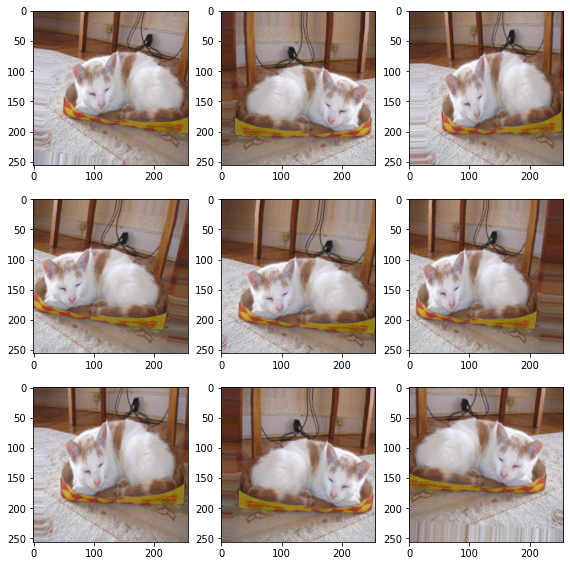

In [ ]:
visual_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1)

visualise_df = train_df.sample(n=1).reset_index(drop=True)
visualisation_generator = visual_datagen.flow_from_dataframe(
    visualise_df,  
    x_col='filename',
    y_col='category'
)
plt.figure(figsize=(8, 8))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in visualisation_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
        
plt.tight_layout()  # 현재 figure상에서 배치되어 있는 그래프 사이의 공백을 적당히 조절 해 주는 것.
plt.show()

<a id="sec2"></a>
# [2. CNN Architecture](#sec2)

Convolutional Neural Network (CNN) has been the to-go neural network architecture when dealing with images. From Yann LeCunn's LeNet in 1990s predicting digits on the popular MNIST data, to Alexnet impressive performance on ImageNet, the area of CNN has evolved tremendously.  
A simple architecture of CNN is shown below:   

![cnn](https://www.researchgate.net/profile/Keiron_Oshea/publication/285164623/figure/fig4/AS:667895516377100@1536250108959/An-simple-CNN-architecture-comprised-of-just-five-layers.png)  
  
**Convolution Layer** uses filters to extract meaningful edges, features in an image, through a combination of linear and non-linear process. Linear operation invloves the correlation between filters and image pixels.Non-linear operations includes ReLU, Tanh.  
![convolution](https://developers.google.com/machine-learning/practica/image-classification/images/convolution_overview.gif)  


**Pooling Layer** aims at reducing the spatial size of the feature map in order to reduce the number of parameters and computation complexity. Some commonly used pooling methods include average pooling, max pooling.  
![pooling](https://developers.google.com/machine-learning/practica/image-classification/images/maxpool_animation.gif)

Images are retreived from [google](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks)

<a id="sec2.1"></a>
## [2.1 CNN from scratch](#sec2.1)

In this section, we will try to implement a CNN architecture from scratch, using the Keras library. We will be using just 5 epochs for all our training

In [ ]:
from keras.applications import VGG16, resnet
from keras.layers import *
from keras.models import Model,Sequential
from keras import optimizers
from keras import regularizers

In [ ]:
from keras import backend as K
K.clear_session()

# Keras는 기능적 모델 구축 API를 구현하고 자동 생성 된 레이어 이름을 단일화하는 데 사용하는 전역 상태를 관리
# 루프에서 많은 모델을 생성하는 경우이 전역 상태는 시간이 지남에 따라 증가하는 메모리를 소비하므로이를 지울 수 있음
# clear_session()를 호출하면 전역 상태가 해제됨
# 이는 특히 메모리가 제한된 경우 이전 모델 및 레이어의 혼란을 방지하는 데 도움이 됨

For our simple CNN, we will use 3 convolutional layers with all having the same filter size of (3x3). Each convolutional layers will be followed by a Max pooling layer that will reduce the dimensions of the convolutional features maps. The output of the final convolutional layer will be passed into a Fully connected layer with 500 neurons, and connecting to the last layer, which acts as sigmoid activation to predict 1/0.

In [ ]:
#model instantiation
modelcnn=Sequential()

# Convolution
modelcnn.add(Conv2D(16, (3,3), activation="relu", input_shape=(img_size, img_size, 3)))  # img_size = 224
modelcnn.add(Conv2D(16, (3,3), activation="relu",))
modelcnn.add(MaxPooling2D((3,3)))

modelcnn.add(Conv2D(32, (3,3), activation="relu"))
modelcnn.add(Conv2D(32, (3,3), activation="relu"))
modelcnn.add(MaxPooling2D(2,2))

modelcnn.add(Conv2D(64, (3,3), activation="relu"))
modelcnn.add(Conv2D(64, (3,3), activation="relu"))
modelcnn.add(MaxPooling2D(2,2))
modelcnn.add(Dropout(0.3))

modelcnn.add(Conv2D(32, (3,3), activation="relu"))
modelcnn.add(MaxPooling2D((2,2)))

# Classifier
modelcnn.add(Flatten())
modelcnn.add(Dense(512, activation="relu"))
modelcnn.add(Dropout(0.5))
modelcnn.add(Dense(1, activation="sigmoid"))  # class_mode='binary'로 설정했기 때문에, 마지막 Dense층의 output갯수는 1

# Compile
modelcnn.compile(loss="binary_crossentropy", 
         optimizer=optimizers.RMSprop(lr=1e-4),
         metrics=["accuracy"])

In [ ]:
modelcnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 69, 69, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)       

Lets fit our model with the training data and evaluate its performance


In [ ]:
# model 실행
modelcnn.fit_generator(
                    train_gen,                # train dataset을 제공할 generater를 지정 (앞서 생성한 train_getn으로 지정)
                    epochs=epochs,            # epochs = 5
                    validation_data=valid_gen # validation_data에 validation dataset을 제공할 valid_gen을 지정
                      )

Epoch 1/5
1172/1172 [==============================] - 234s 200ms/step - loss: 0.6761 - accuracy: 0.5620 - val_loss: 0.6422 - val_accuracy: 0.6269
Epoch 2/5
1172/1172 [==============================] - 233s 198ms/step - loss: 0.6268 - accuracy: 0.6499 - val_loss: 0.7773 - val_accuracy: 0.6118
Epoch 3/5
1172/1172 [==============================] - 232s 198ms/step - loss: 0.5971 - accuracy: 0.6817 - val_loss: 0.5105 - val_accuracy: 0.7216
Epoch 4/5
1172/1172 [==============================] - 230s 196ms/step - loss: 0.5553 - accuracy: 0.7155 - val_loss: 0.2064 - val_accuracy: 0.7510
Epoch 5/5
1172/1172 [==============================] - 230s 196ms/step - loss: 0.5260 - accuracy: 0.7394 - val_loss: 0.5404 - val_accuracy: 0.7590


In [ ]:
# model 평가
loss, accuracy = modelcnn.evaluate_generator(
    valid_gen,                        # validation dataset을 제공할 valid_gen을 지정
    valid_gen.samples//batch_size,    # 중지되기 전까지 generator로부터 얻는 단계의 총 갯수 (샘플의 batch)
    workers=12                        # 가속을 위한 프로세스의 최대 갯수
)

print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Validation: accuracy = 0.758974  ;  loss = 0.440359 


<a id="sec2.2"></a>
## [2.2 Transfer Learning](#sec2.2)

In the following sections, we will be focusing on **Pre-trained** models. Pre-trained models are architectures are were previously trained using large datasets to solve similar problems that we are trying to solve; which is image classification.  
One benefits of using pre-trained model is that because these models has been trained on huge datasets, they are used to learning very good discriminative features, enabling us to use it for transfer learning.  
**Transfer learning** is process of reusing a pretained model trained for a task and use it for another task. Two approaches for transfer learning are:
1. Feature Extraction
2. Fine Tuning

<a id="sec2.2.1"></a>
### [2.2.1 Feature Extraction](#sec2.2.1)

One of the approach for transfer learning is **feature extraction**, where we leverage on the pretrained models to predict a set of output features, and feeding these output features into a separate classifier algorithm to generate prediction. In this case, we will be using [VGG16](https://arxiv.org/pdf/1409.1556.pdf) as our feature extractor, and using **Logistic Regression** as our binary classifier

What we are doing here is to freeze the VGG16 layers up to the dense layer; output from the model will have a shape of 7x7x512.   
![feat_extraction](https://i2.wp.com/appliedmachinelearning.blog/wp-content/uploads/2019/07/vgg16-1.png?w=1200&ssl=1)
Image referenced from [here](https://appliedmachinelearning.blog/2019/07/29/transfer-learning-using-feature-extraction-from-trained-models-food-images-classification/)

By setting *include_top = False*, we essentially removed the fully connected layers from the pretrained VGG16 model. The output from the VGG16 output layer will be an array with shape(sample_size, 7,7,512)

In [ ]:
vgg = VGG16(weights='imagenet',
                  include_top=False,          
                  input_shape=(224, 224, 3))

for layers in vgg.layers:
    layers.trainable=False

print(vgg.output)

58892288/58889256 [==============================] - 1s 0us/step
Tensor("block5_pool/MaxPool:0", shape=(None, 7, 7, 512), dtype=float32)


We will use training set as our data that will be further split into train-test, due to memory constraint. The shape of the output features will be (18750, 25088)

In [ ]:
feature_list = []
for path in train_df['filename'].to_numpy():
    x = load_img(path,target_size=(img_size,img_size))
    img_array = img_to_array(x)
    img_array = np.expand_dims(img_array, axis=0)  # 차원 추가 ( 4차원으로 만들어주기 )
    features = vgg.predict(img_array)
    feature_list.append(features)
    
feat_lst = np.reshape(feature_list,(-1,7*7*512))  

In [ ]:
del feature_list
print(feat_lst.shape)

(18750, 25088)


In [ ]:
feat_lst[3:10]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  3.3346465 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [45.573444  ,  0.        ,  8.923744  , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         6.579592  ,  0.        ],
       [19.467281  ,  0.        ,  0.        , ...,  0.        ,
        24.321962  ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.60549706,  0.        ]], dtype=float32)

#### Logistic Regression
Features generated from VGG will be fed into Logistic Regression Model for classification. The logistic regression will output whether the features represent a Dog or a Cat

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

y = train_df['category'].to_numpy()  # convert df to numpy array with shape(18750,)

X_train, X_test, y_train, y_test = train_test_split(feat_lst, y, test_size=0.2, random_state=2020)

# 모델 선언
glm = LogisticRegression(C=1)  # C는 cost function을 의미하는 하이퍼 파라미터.
                                  # L1 or L2 제약조건의 강도를 설정 (강한 규제 feature 수를 줄이는 것)
                                  # C가 높을수록 낮은 강도의 제약조건이 설정 
                                  # C는 계산되는 기울기들을 0쪽으로 잡아두는 정도를 의미함
                                  # C가 높을수록 낮은 강도의 제약조건이 설정 -> 데이터 쪽으로 치우치게 됨
                                  # C가 낮을수록 높은 강도의 제약조건이 설정 -> 0으로 치우치게 됨

# 모델 실행
glm.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print("Accuracy on validation set using Logistic Regression: ",glm.score(X_test,y_test))

Accuracy on validation set using Logistic Regression:  0.9712


<a id="sec2.2.2"></a>
### [2.2.2 Fine Tuning](#sec2.2.2)

Fine tuning on a pretrained model involves training some of the layers instead of freezing all the weights.

In this example, we will be using the pretrained [ResNet](https://arxiv.org/pdf/1512.03385.pdf) for fine tuning, by doing the following:  
1. Freezing the first 171 layers and only training the last 4 layers in Resnet. 
2. Adding our own fully connected layer with 1024 neurons.
3. Add a single neuron Dense layer with sigmoid activation as our classifier.


In [ ]:
len(res.layers)

175

In [ ]:
res.layers

In [ ]:
np.random.seed(2020)

res = resnet.ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

res_train_gen = generate_train_batch('resnet')
res_valid_gen = generate_valid_batch('resnet')


# Freezing the first 171 layers and only training the last 4 layers in Resnet.
for layer in res.layers[:171]:
    layer.trainable=False
    

flat = Flatten()(res.output)                 # Flatten the output layer from our Resnet model
dense = Dense(1024,activation='relu')(flat)  # Adding our own fully connected layer with 1024 neurons.
drop = Dropout(0.5)(dense)
classifier = Dense(1, activation='sigmoid')(drop) # Add 1 neuron Dense layer with sigmoid activation as our classifier.


res_model = Model(res.input, classifier)
optimizer = optimizers.Adam(1e-5)


res_model.compile(optimizer= optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

res_model.fit_generator(res_train_gen,
                    epochs=epochs,
                    validation_data=res_valid_gen,
                    validation_steps=res_train_gen.samples//batch_size,
                    steps_per_epoch = res_valid_gen.samples//batch_size)

94773248/94765736 [==============================] - 1s 0us/step
resnet data
Found 18750 validated image filenames belonging to 2 classes.
resnet validation set
Found 6250 validated image filenames belonging to 2 classes.
Epoch 1/5
390/390 [==============================] - 167s 428ms/step - loss: 0.2293 - accuracy: 0.9301 - val_loss: 0.0665 - val_accuracy: 0.9821
Epoch 2/5
390/390 [==============================] - 161s 413ms/step - loss: 0.1646 - accuracy: 0.9509 - val_loss: 1.2116e-04 - val_accuracy: 0.9832
Epoch 3/5
390/390 [==============================] - 161s 412ms/step - loss: 0.1463 - accuracy: 0.9545 - val_loss: 0.0900 - val_accuracy: 0.9718
Epoch 4/5
390/390 [==============================] - 162s 416ms/step - loss: 0.1115 - accuracy: 0.9617 - val_loss: 0.0650 - val_accuracy: 0.9809
Epoch 5/5
390/390 [==============================] - 161s 412ms/step - loss: 0.0861 - accuracy: 0.9711 - val_loss: 0.3737 - val_accuracy: 0.9843


In [ ]:
loss, accuracy = res_model.evaluate_generator(res_valid_gen, res_valid_gen.samples//batch_size, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Validation: accuracy = 0.984455  ;  loss = 0.034582 


<a id='sec3'></a>
# [3. Results](#sec3)

We will make predictions on 12 images collected from the **test data**, using the 3 architectures we have built thus far; [Custom CNN](#sec2.1), [Feature Extraction](#sec2.2.1) and [Fine Tuning](#sec2.2.2).

In [ ]:
# define function for evaluating model performance on test images

testdf = pd.DataFrame({'filename': test_x})
test_sample = testdf.sample(n=12, random_state=2020)  # make predictions on 12 images collected from the test data

def test_img(model,name):
    result_lst = []
    for path in test_sample['filename'].to_numpy():
        full_path = '../test1/'+path
        x = load_img(full_path, target_size=(224,224))
        img_array = img_to_array(x)
        img_array = np.expand_dims(img_array, axis=0)
        if name == 'vgg':
            features = model.predict(img_array)
            features = np.reshape(features,(-1,7*7*512))
            result = glm.predict(features)
        else:
            result =  model.predict(img_array)
        
        result = 'dog' if float(result) > 0.5 else 'cat'
        
        result_lst.append(result)
    return result_lst

In [ ]:
# get test predictions from all models
custom_cnn_result = test_img(modelcnn, 'cnn')
trflearn_result = test_img(vgg,'vgg')
finetune_result = test_img(res_model,'resnet')

The architecture using Transfer Learning and Fine tuning makes pretty good prediction, agreeing with each other on almost all the images, except one, which the Fine tuning method has incorrectly predicted a Dog as Cat. Our Custom CNN doesnt really work very well with alot of false positive (missclassifying Cats as Dogs).

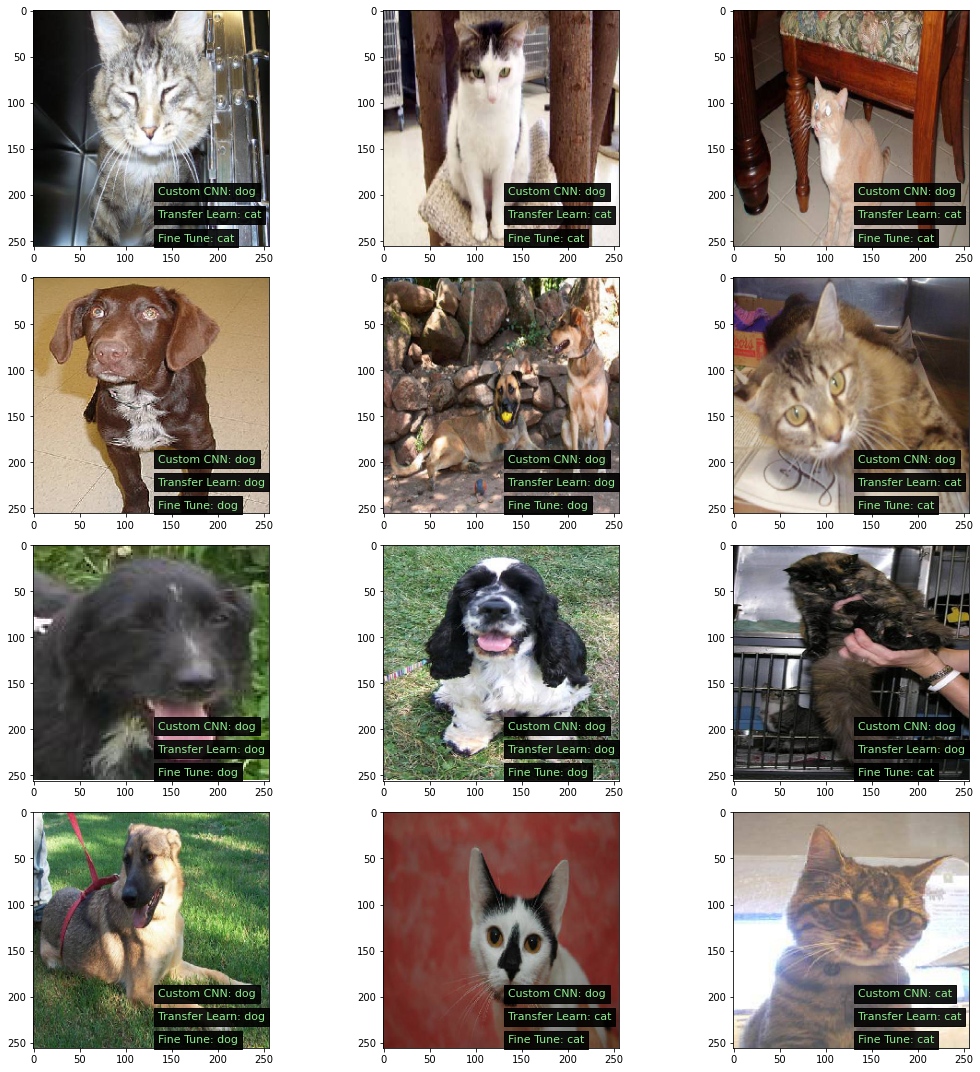

In [ ]:
# plotting images with prediction
pred_results  = list(zip(custom_cnn_result,trflearn_result,finetune_result))
test_array = test_sample['filename'].to_numpy()

plt.figure(figsize=(15, 15))
for i in range(0, 12):
    plt.subplot(4, 3, i+1)
    cust,tf,ft = pred_results[i]
    img = test_array[i]
    path = '../test1/' + img
    image = load_img(path, target_size=(256,256))
    plt.text(135, 200, 'Custom CNN: {}'.format(cust), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 225, 'Transfer Learn: {}'.format(tf), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 250, 'Fine Tune: {}'.format(ft), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.imshow(image)

plt.tight_layout()
plt.show()

#### Learning Points
1. Setting a learning rate small enough is very important in the case of Transfer Learning and Fine Tuning, as i realized that setting learning rate to be 1e-4 will result in very low accuracy ~50%. This could be due to the complex loss function, thus, causing divergence during gradient updates if learning rate is not small enough.
2. Images passed into ResNet needs to be preprocessed via the specific preprocessing function provided *from keras.applications.resnet50 import preprocess_input* when generating mini-batches, as it will affect the performance of ResNet if standard preprocessing is done instead.
3. Due to memory constraint from Kaggle Kernel (~13GB), there is possibility of the kernel crashing. What i did to mitigate this is to use the *del* function, to remove some of the variables; feature output object from VGG16. I believe there are much better ways to do it, any advice from the experienced Kagglers will be much appreciated :)

### Please Upvote this notebook if it has helped you in any ways :) Thank you !

I hope you guys have enjoyed following through this notebook. Do ping me up for any mistakes or doubts:)  

Cheers  
![](https://initiate.alphacoders.com/images/741/cropped-150-150-741057.jpg?8466)

#### References 

Some references i have taken from: [@bulentsiyah](https://www.kaggle.com/bulentsiyah) and [@serkanpeldek](https://www.kaggle.com/serkanpeldek)

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html  
https://www.learnopencv.com/keras-tutorial-using-pre-trained-imagenet-models/  

#### For Submission

In [ ]:
# test_generator = ImageDataGenerator(rescale=1./255)
# test_gen = test_generator.flow_from_dataframe(
#     testdf,
#     '../test1',
#     x_col='filename',
#     y_col=None,
#     class_mode=None,
#     batch_size=batch_size,
#     target_size=(img_size, img_size),
#     shuffle=False
# )

In [ ]:
# predict = model.predict_generator(test_gen, steps=test_gen.samples/batch_size)
# threshold = 0.5
# testdf['category'] = np.where(predict > threshold, 1,0)

### (Add-ons) Pytorch Implementation for Resnet Finetuning

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os

In [ ]:
class CatDogData(Dataset):
    def __init__(self, direct, df, transform):
        self.dir = direct
        self.df = df
        self.transform = transform
        
    def __getitem__(self, idx):
        img, label = self.df.iloc[idx]
        path = os.path.join(self.dir, img)
        img_array = Image.open(path)
        
        if self.transform:
            img_array = self.transform(img_array)
        label = torch.as_tensor(int(label))
        
        return img_array, label
    
    def __len__(self):
        return self.df.shape[0]

#### Augmentation

In [ ]:
from torchvision import transforms

train_trf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

valid_trf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
])

#### Create dataloader for mini batch training

In [ ]:
train_data = CatDogData('/kaggle/working/temp/train', train_df, train_trf)
valid_data = CatDogData('/kaggle/working/temp/train', valid_df, valid_trf)

train_loader = DataLoader(train_data, batch_size = 32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)

#### Model

In [ ]:
from torchvision.models import resnet50
import torch.nn as nn

In [ ]:
model = resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
!pip install torchsummary

In [ ]:
c = 0
for child in model.children():
    if c < 9:
        for param in child.parameters():
            param.requires_grad = False
    c+=1

In [ ]:
output_layer = nn.Linear(1000, 2)
model = nn.Sequential(model, output_layer)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
import tqdm

In [ ]:
class Fitter:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        
        param_list = [p for p in model.parameters() if p.requires_grad]
    
        self.optimizer = torch.optim.Adam(param_list, lr = 1e-5)
        
        self.criterion = nn.CrossEntropyLoss()
        
    def fit(self, model, train_loader, valid_loader):
        bst_loss = 10
        print(f'Model running with {self.device}')
        for epoch in range(5):
            self.train_one_epoch(model, train_loader)
            val_loss = self.validate(model, valid_loader)
            
            print("Previous loss: {} Current loss: {}".format(bst_loss, val_loss))
            if val_loss < bst_loss:
                model.eval()
                torch.save(model, f'{epoch}.pth')
                bst_loss = val_loss
            
    def train_one_epoch(self, model, train_loader):
        itr = 1
        loss_hist = Averager()
        self.model.train()
        
        for images, targets in train_loader:
            images = images.to(self.device).float()
            targets = targets.to(self.device)

            output = self.model(images)
            loss = self.criterion(output, targets)
            loss_hist.send(loss.item())

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
                
            if itr % 100 == 0:
                print(f"Iteration #{itr} loss: {loss.item()}")


            itr += 1
                
        print(f"Training Epoch loss: {loss_hist.value}")
        loss_hist.reset()
        
        
    def validate(self, model, valid_loader):
        acc = 0
        val_loss = 0
        loss_hist = Averager()
        self.model.eval()
        
        for images, targets in valid_loader:
            with torch.no_grad():
                images = images.to(self.device).float()
                targets = targets.to(self.device)

                output = self.model(images)
                loss = self.criterion(output, targets)
                loss_hist.send(loss.item())

                #acc
                log = torch.sigmoid(output)
                pred = torch.argmax(log, 1)
                acc += (targets.cpu() == pred.cpu()).sum().item()
                

        val_loss = loss_hist.value    
        print(f"Validation Epoch loss: {loss_hist.value}")
        loss_hist.reset()
        print("Validation Accuracy: {}".format(acc/len(valid_data)))
        
        return val_loss

In [ ]:
run_model = Fitter(model, device)
run_model.fit(model, train_loader, valid_loader)

Model running with cuda
Iteration #100 loss: 0.1892269253730774
Iteration #200 loss: 0.14610856771469116
Iteration #300 loss: 0.0786978006362915
Iteration #400 loss: 0.05036715790629387
Iteration #500 loss: 0.051815252751111984
Training Epoch loss: 0.07915056450610325
Validation Epoch loss: 0.057417289159089634
Validation Accuracy: 0.9792
Previous loss: 10 Current loss: 0.057417289159089634
Iteration #100 loss: 0.04779121279716492
Iteration #200 loss: 0.04092851281166077
Iteration #300 loss: 0.12568357586860657
Iteration #400 loss: 0.043749965727329254
Iteration #500 loss: 0.03505134582519531
Training Epoch loss: 0.06781100665629164
Validation Epoch loss: 0.05105126926637426
Validation Accuracy: 0.9808
Previous loss: 0.057417289159089634 Current loss: 0.05105126926637426
Iteration #100 loss: 0.10469413548707962
Iteration #200 loss: 0.004762155935168266
Iteration #300 loss: 0.04201715812087059
Iteration #400 loss: 0.050906017422676086
Iteration #500 loss: 0.011586441658437252
Training E